# Прогнозирование объемов транзита нефти на основе технологии моделирования временных рядов

Для сравнение технологий глубокого обучения применительно к исследуемому набору данных в работе рассмотрены результаты прогнозирования показателей на один и несколько шагов (месяцев) в будущее с использованием различных моделей.

## Настройка среды

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Набор данных

Набор данных включает период с 1965 по 2021 год. Детальная информация о наборе описана в главе 3.2 

In [2]:
df = pd.read_excel('tdn_11.xlsx', index_col = 'index')

Модели предназначены для прогнозирования ежемесячных объемов как и набор данных

In [3]:
date_range = pd.date_range('01/01/1965', periods=df['All'].count(), freq = 'M')

Несколько последних строк набора данных

In [4]:
df.tail()

,M,Q,Year,All,Mozyr,Brest,Brody,MNPZ,Price,Product,EV
index,,,,,,,,,,,
679,8,3,2021,3931746,3743356,2072894,977602,881250,68.33,44093.5,26.0
680,9,3,2021,3743145,3441733,2178307,802605,762233,72.50,43859.1,27.0
681,10,4,2021,3657820,3408730,2114266,816592,726962,81.71,45857.0,28.0
682,11,4,2021,3743145,3441733,2178307,802605,762233,79.98,45300.0,29.0
683,12,4,2021,3730496,3743356,2072894,977602,680000,83.00,44800.0,30.0


Here is the evolution of a few features over time:

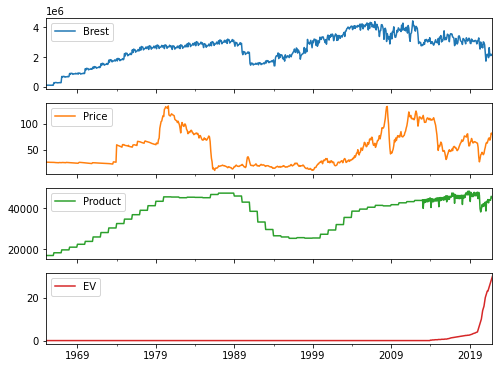

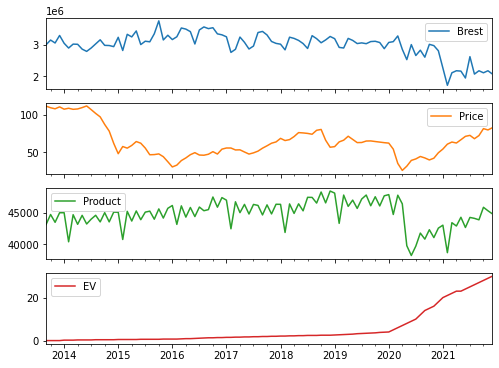

In [5]:
plot_cols = ['Brest', 'Price', 'Product', 'EV']
plot_features = df[plot_cols]
plot_features.index = date_range
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][-100:]
plot_features.index = date_range[-100:]
_ = plot_features.plot(subplots=True)

### Обзор и очистка данных

Ниже приведена общая статистика по набору данных

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
M,684.0,6.500000e+00,3.454579e+00,1.000000e+00,3.750000e+00,6.500,9.250,12.00
Q,684.0,2.500000e+00,1.118852e+00,1.000000e+00,1.750000e+00,2.500,3.250,4.00
Year,684.0,1.993000e+03,1.646399e+01,1.965000e+03,1.979000e+03,1993.000,2007.000,2021.00
All,684.0,4.862720e+06,1.546007e+06,1.109370e+06,3.864714e+06,5172751.000,6185375.000,7283211.00
Mozyr,684.0,4.823764e+06,1.532038e+06,1.106863e+06,3.832239e+06,5091369.500,6145219.000,7257030.00
Brest,684.0,2.589989e+06,9.665420e+05,1.031520e+05,1.993415e+06,2771767.000,3179243.250,4412498.00
Brody,684.0,1.540018e+06,6.237597e+05,0.000000e+00,1.276291e+06,1582425.000,2003857.500,2574727.00
MNPZ,684.0,6.646873e+05,4.457715e+05,0.000000e+00,3.275300e+05,701439.500,999962.000,1462916.00
Price,684.0,4.963087e+01,3.231234e+01,9.560000e+00,2.301000e+01,41.995,69.485,134.79
Product,684.0,3.668313e+04,9.079308e+03,1.683333e+04,2.808333e+04,40432.000,44999.900,48443.90


#### Дата и цикличность данных

Непосредственно колонка M (месяц) и Q (квартал) не являются полезными для обучения модели, поэтому преобразуем их в функции синуса и косинуса

In [7]:
timestamp_s = date_range.map(pd.Timestamp.timestamp)

Преобразование номера месяца и квартала в sin() и cos() позволит модели изучить циклические сезонные зависимости

In [8]:
day = 24*60*60
year = (365.2425)*day
month = year/12
quart = year/4

df['M sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['M cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Q sin'] = np.sin(timestamp_s * (2 * np.pi / quart))
df['Q cos'] = np.cos(timestamp_s * (2 * np.pi / quart))

Text(0.5, 1.0, 'Периодические сигналы')

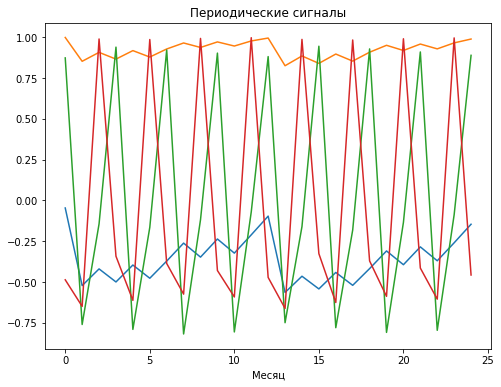

In [9]:
plt.plot(np.array(df['M sin'])[:25])
plt.plot(np.array(df['M cos'])[:25])
plt.plot(np.array(df['Q sin'])[:25])
plt.plot(np.array(df['Q cos'])[:25])
plt.xlabel('Месяц')
plt.title('Периодические сигналы')

Анализ данных с помощью быстрого преобразования Фурье не обнаруживает сколь нибудь значительных пиков. Одновременно заметны пики на уровне квартала и года. 


2022-01-09 22:00:56.539193: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


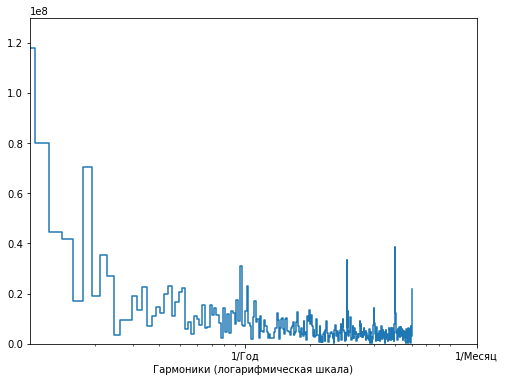

In [10]:
fft = tf.signal.rfft(df['All'])
f_per_dataset = np.arange(0, len(fft))

n_samples_m = len(df['Brest'])
month_per_year = 12
years_per_dataset = n_samples_m/(month_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 0.13*1e9)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12], labels=['1/Год', '1/Месяц'])
_ = plt.xlabel('Гармоники (логарифмическая шкала)')

### Разделение набора на тренировочный, проверочный и тестовый

В исследовании используется разделение (100%, 20%, 10%) для обучение, проверки и тестов. Без перемешивания перед разделение по причине временных зависимостей между отдельными строками. 
В связи с ограниченным набором данных и важными процессами (такими как появление электротранспорта), которые возникли только в последние годы участки данных для обучения и проверки перекрываются. Данное допущение в исследовании моделей вынужденная мера и она будет устранена по мене пополнения набора данных.

In [11]:
#удаляем лишние колонки M и Q
df = df.drop(columns=['M','Q'])

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = pd.concat([df[0:int(n*0.6)],df[int(n*0.6):]])
val_df = df[int(n*0.6):int(n*0.8)]
test_df = df[int(n*0.8):int(n*0.9)]

num_features = df.shape[1]

### Нормализация данных

Нормализация (масштабирование) данных перед началом обучения нейросети является важным шагом. В общем случае нормализация вычисляется как частное от сренднего значения на стандартное отклонение для каждого параметра.

Для лучшего качества модели необходимо расчитывать параметры нормализации только для тренировочного набора не затрагия проверочного и тестового.

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

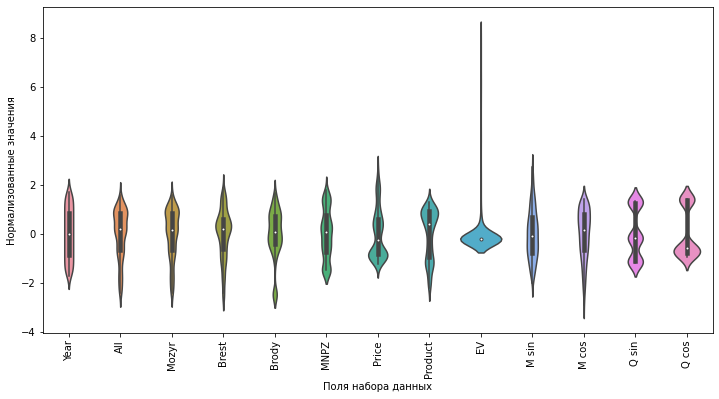

In [13]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Поля набора данных', value_name='Нормализованные значения')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Поля набора данных', y='Нормализованные значения', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Информационное окно

Модели в этой работе делают прогноз на основе окна последовательных данных.

Основные особенности окон ввода:

Ширина (количество временных шагов) окон ввода и меток.
Временной сдвиг между ними.
Какие функции используются в качестве входных данных, меток или и того, и другого.
В работе рассматриваются различные модели (в том числе линейные модели, модели DNN, CNN и RNN), которые используются для двух видов прогнозирования:

С одним выходным значением, и мульти-параметрические прогнозы.
Одно- и мульти-шаговое предсказание.

Ниже рассматривается реализации окна данных, чтобы его можно было повторно использовать для всех видов моделей.

В зависимости от задачи и типа модели мы будем генерировать различные окна данных. Вот некоторые примеры:

1. Например, чтобы сделать одно предсказание на 24 периода вперед с учетом 24 периодов истории, можно определить такое окно:
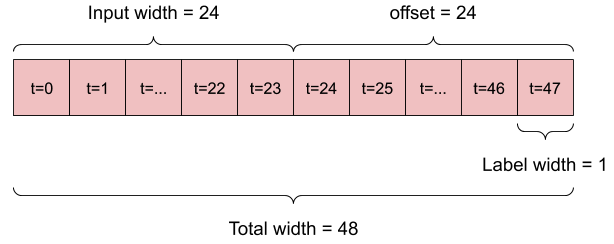

2. Модель которая делает прогноз на 1 период вперед, на основе 6-и месячной истории, потребует следующее окно:
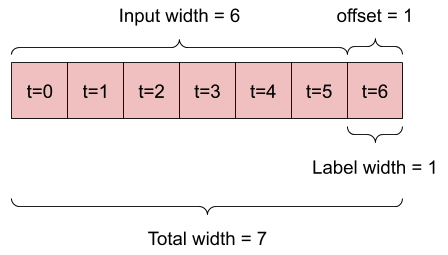

### 1. Индексы и смещения

Ниже представдлен класс WindowGenerator, который обеспечивает формирование необходимых окон, а также объединяет данные для обучения и тестирования в общий входной набор `tf.data.Dataset`


In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Сохраняем входную информацию
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Определяем индексы наименований столбцов.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Опрделяем параметры окон.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Код ниже показывает создание окон с параметрами как на рисунках показанных в этом разделе

In [15]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Brest'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Brest']

In [16]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Brest'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Brest']

### 2. Сплит (разделение)

Метод split_window преобразет исходное окно в окно входов и окно меток.

Для выше показанного примера w2 можно определить разделение как на рисунке:
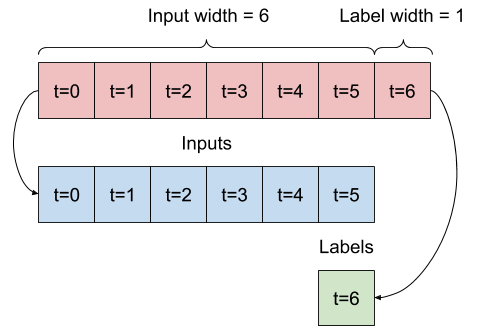


In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  #информацию о размерности надо установить вручную
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Проверим:

In [18]:
# Сформируем три образца протяженностью total_window_size каждый.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('Все формы:(batch, time, features)')
print(f'Window форма: {example_window.shape}')
print(f'Inputs форма: {example_inputs.shape}')
print(f'Labels форма: {example_labels.shape}')

Все формы:(batch, time, features)
Window форма: (3, 7, 13)
Inputs форма: (3, 6, 13)
Labels форма: (3, 1, 1)


Window форма описывает три пакета, протяженностью 7 шагов каждый с 29 параметрами для каждого шага.
Input форма - входные исторические данные для прогнозирования Labels, которые состоят из трех пакетов, протяженностью 6 шагов каждый с 29 параметрами для каждого шага.
Labels - целевое значение, форма состоит из 3 пакетов по 1 шагу с 1 параметром.


### 3. Графики

Для оценки результата прогнозирования лучшим методом является простая визуализация:

In [19]:
w2.example = example_inputs, example_labels

In [20]:
def plot(self, model=None, plot_col='Brest', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Месяц')

WindowGenerator.plot = plot

Этот график выравнивает входные данные, метки и (более поздние) прогнозы в зависимости от времени, на которое ссылается элемент:

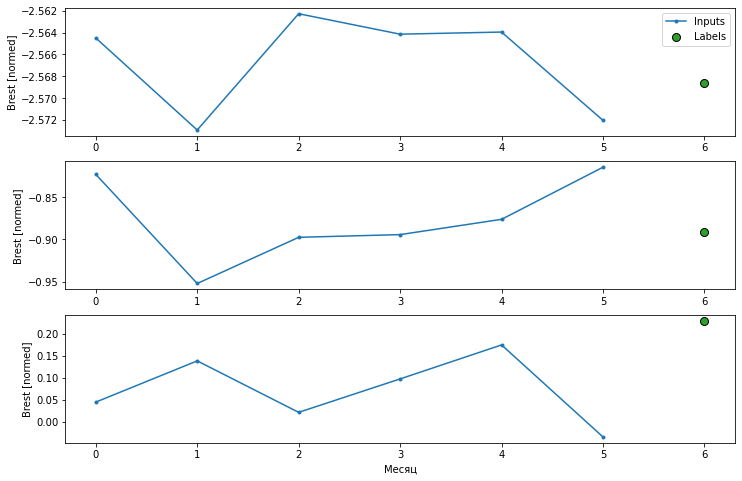

In [21]:
w2.plot()

Вы можете построить другие столбцы, но пример окна `w2`, только в данной конфигурации метки есть только у поля `Brest`.

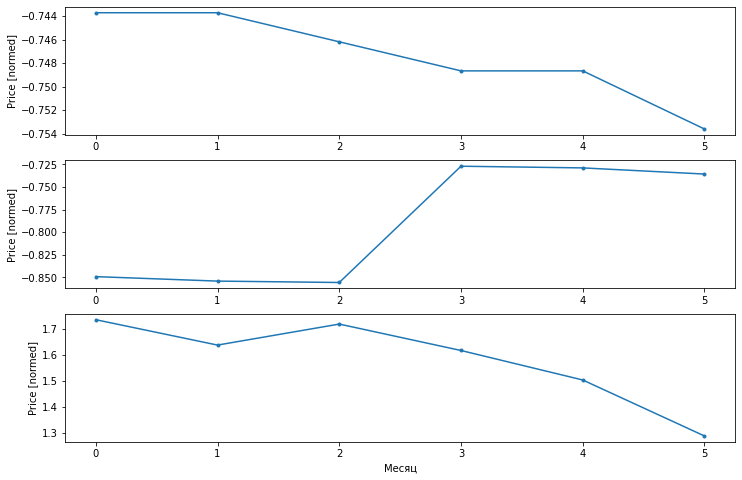

In [22]:
w2.plot(plot_col='Price')

### 4. Создание `tf.data.Dataset`

Метод `make_dataset` будет создавать временную последовательность в виде DataFrame и преобразовывать в  `tf.data.Dataset` из `(input_window, label_window)` пар с использованием функции `preprocessing.timeseries_dataset_from_array`:

In [23]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

Объект `WindowGenerator` должен содержать информацию для обучения, проверки и тестирования.

Необходимо добавить свойства для доступа к `tf.data.Dataset`. Также добавим стандартный метод для простого доступа и печати:

In [24]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # Образцов для примера не нашлось, тогда возьмем один з учебного набора
    result = next(iter(self.train))
    # и запомним на следующий рах
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Теперь объект `WindowGenerator` предоставляет доступ к объекту `tf.data.Dataset`.

Свойство `Dataset.element_spec` содержит структуру, типы данных и формы элементов набора данных.

In [25]:
# Каждый элемент это пара (inputs, label).
w2.train.element_spec

(TensorSpec(shape=(None, 6, 13), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Наполним `Dataset` настоящими пакетами данных:

In [26]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 13)
Labels shape (batch, time, features): (32, 1, 1)


## Модели с одношаговым прогнозом

Самая простая модель, которая рассматривается в исследовании - это модель, которая предсказывает значение отдельной функции на 1 временной шаг (один месяц) в будущее на основе только текущих условий.

Итак, начнем с построения моделей для прогнозирования объема транспортировки в направлении Бреста (`Brest`) на один в месяц вперед.

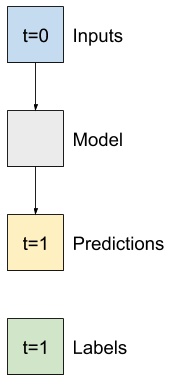

Настраиваем объект `WindowGenerator` для производства одношаговых пар `(input, label)`:

In [27]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Brest'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Brest']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [28]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 13)
Labels shape (batch, time, features): (32, 1, 1)


### Исходный уровень

Перед исследованием обучаемой модели хорошо иметь базовый уровень производительности в качестве точки для сравнения с более поздними более сложными моделями.

Эта первая задача - предсказать объем транспортировки на один месяц в будущем, учитывая текущее значение всех функций. Текущие значения включают текущий объем транспортировки.

Итак, начнем с модели, которая просто возвращает текущий объем транспортировки в качестве прогноза с прогнозом «Без изменений». Это разумный исходный уровень, поскольку объем транспортировки изменяется медленно. Конечно, этот базовый уровень будет работать хуже, если делать дальние прогнозы в будущее.

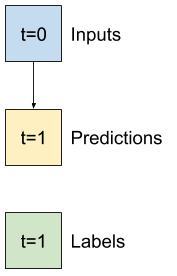


In [29]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Создадим и оценим эту модель:

In [30]:
baseline = Baseline(label_index=column_indices['Brest'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 2ms/step - loss: 0.0713 - mean_absolute_error: 0.2103


Полученные показатели производительности не позволяют оценить насколько хорошо работает модель. 

Для оценки создадим более широкий WindowGenerator, который создает окна протяженностью 24 месяца входов и меток одновременно. Новая переменная wide_window переменная не меняет способ работы модели. Модель по-прежнему делает прогнозы на один месяц вперед на основе одного временного шага ввода:

In [31]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Brest'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Brest']

В итоге получается некоторое подобие пакетной обработки когда каждый шаг дает прогноз который равен значению параметров на следующем шаге:

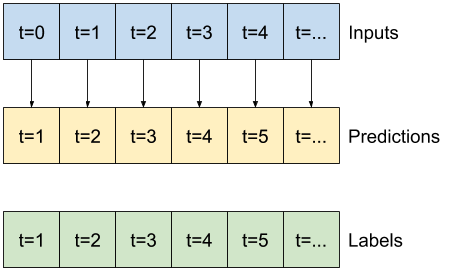

In [32]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


При построении прогнозов базовой модели хорошо видно, что это просто метки, сдвинутые вправо на один месяц:

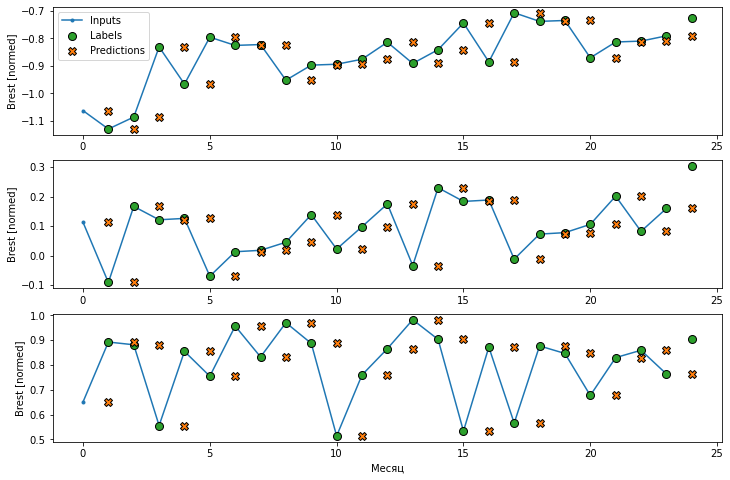

In [33]:
wide_window.plot(baseline)

На приведенных выше графиках одношаговая модель обрабатывает 24 месяца. 

Синие Inputs линии показывают входные значения - объем транспортировки (Брест) на каждом временном шаге. Модель получает все параметры, этот график показывает только объем транспортировки.
Зеленые Labels точки показывают целевые значения прогнозируемого параметра. Эти точки отображаются во время прогнозирования, а не во время ввода. Поэтому диапазон меток сдвинут на 1 шаг относительно входов.
Оранжевые Predictions кресты - прогнозы модели для каждого временного шага вывода. Если модель сформировала идеальный прогноз - Predictions совпадет с Labels.

### Линейная модель

Это самая простая обучаемая модель которую можно применить к этой задаче, чтобы вставить линейное преобразование между входом и выходом. В этом случае результат временного шага зависит только от этого шага:
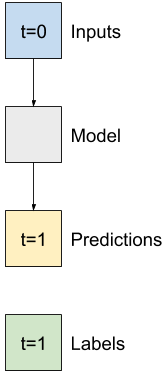
Слой `tf.keras.layers.Dense` без `activation` является линейной моделью. Слой только преобразует последнюю осб данных из `(batch, time, inputs)` в `(batch, time, units)`; Она применяется независимо к каждому элементу данных поперек `batch` и `time` осей.

In [34]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [35]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 13)
Output shape: (32, 1, 1)


В исследовании обучается множество моделей, поэтому упакуем процедуру обучения в функцию:

In [36]:
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Обучим модель и оценим ее производительность:

In [37]:
history = compile_and_fit(linear, single_step_window)
IPython.display.clear_output()
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 2ms/step - loss: 0.5775 - mean_absolute_error: 0.6848


Как и `baseline` модель, линейная модель вызывает партии широких окон (по 24 месяца). При таком использовании модель делает набор независимых прогнозов на последовательных временных шагах. Ось `time` действует как другая `batch` ось. Между прогнозами на каждом временном шаге нет взаимосвязи.

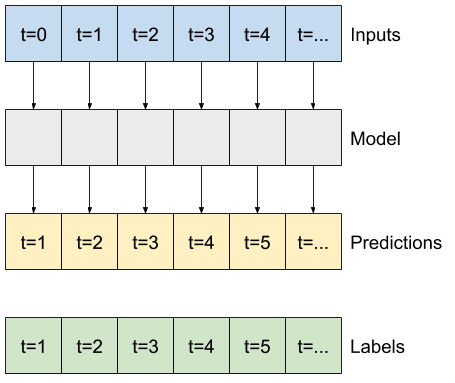

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


Обратите внимание, как в некоторых случаях прогнозы лучше, чем просто возвращение значения ввода, но в некоторых случаях хуже:

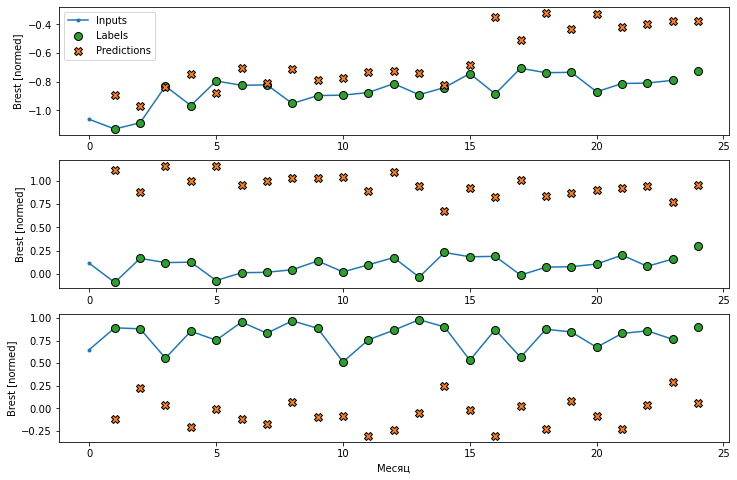

In [39]:
wide_window.plot(linear)

Одним из преимуществ линейных моделей является то, что их относительно легко интерпретировать. Мы можем вытащить веса слоя и визуализировать вес, назначенный каждому входу:

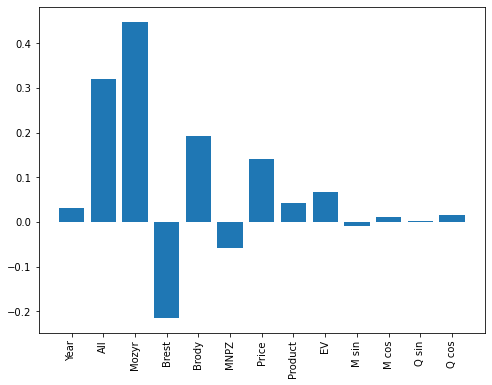

In [40]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Иногда модель не назначает наибольший вес на прогнозируемый входной параметр `Brest`. Это один из рисков случайной инициализации. 

### Плотная сеть (сеть прямого распространения)

Прежде чем применять модели, которые фактически работают с несколькими временными шагами, стоит проверить производительность более глубоких, более мощных моделей с одним входом.

Эта модель похожа на `linear` модель, за исключением того, что включает стек нескольких `Dense` слоев между входом и выходом:


In [41]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)
IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 3ms/step - loss: 0.0282 - mean_absolute_error: 0.1300


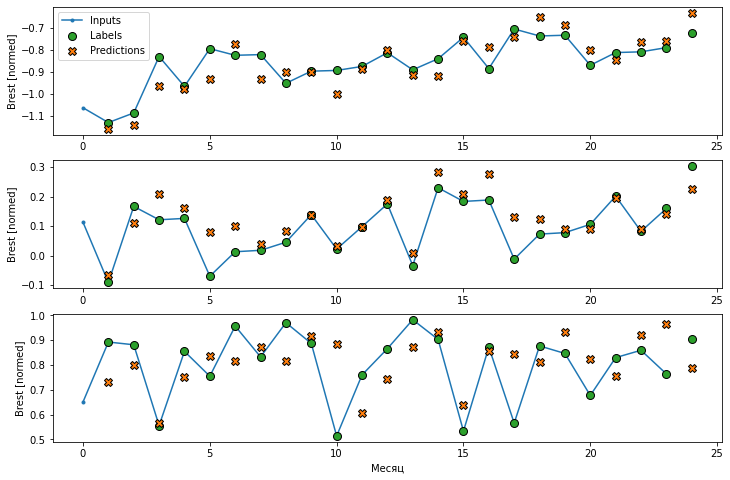

In [42]:
wide_window.plot(dense)

### Многоступенчатая плотная сеть

Модель с одним временным шагом не имеет контекста для текущих значений входных данных. Она не может видеть, как входные функции меняются с течением времени. Для решения этой проблемы модели требуется доступ к нескольким временным шагам при прогнозировании:

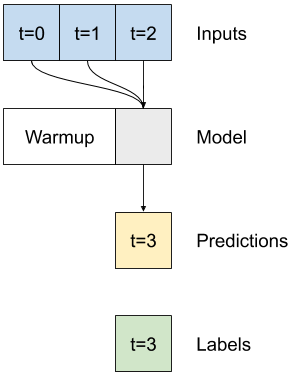


Модели `baseline`, `linear` и `dense` обрабатывают каждый шаг времени независимо друг от друга. Эта модель примет несколько временных шагов в качестве входных данных для получения единственного выхода.

Создание WindowGenerator , который будет производить партии три часа входов и один час меток:

Обратите внимание , что в Window «сек shift параметр по отношению к концу двух окон.
Создаем `WindowGenerator` который будет производить пакеты из трех входных месяцев и одной одно-месячной метки:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [43]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Brest'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Brest']

Text(0.5, 1.0, 'Берем 3 месяца входных данных и прогнозируем 1 месяц в будущем.')

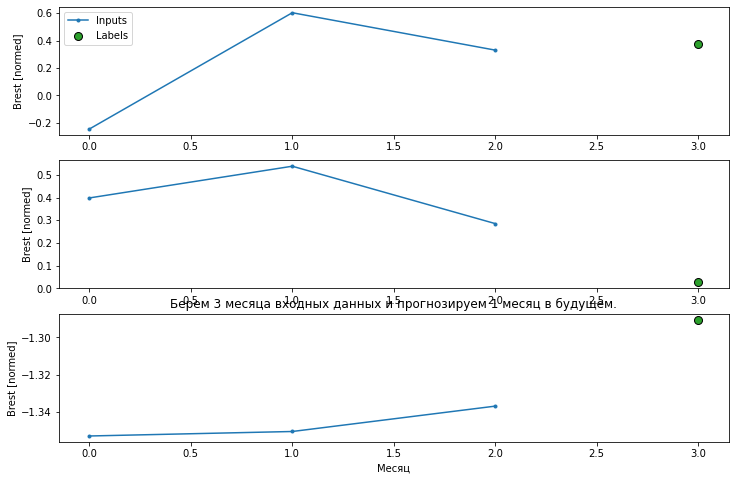

In [44]:
conv_window.plot()
plt.title("Берем 3 месяца входных данных и прогнозируем 1 месяц в будущем.")

Для обучение `dense` модель на нескольких входных шагах добавляем tf.keras.layers.Flatten в качестве первого слоя модели:

In [45]:
multi_step_dense = tf.keras.Sequential([
    # Форма: (время, параметры) => (время*параметры)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Добавляем обратное измерение времени.
    # форма: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [46]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


In [47]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

5/5 [==============================] - 0s 3ms/step - loss: 0.0367 - mean_absolute_error: 0.1469


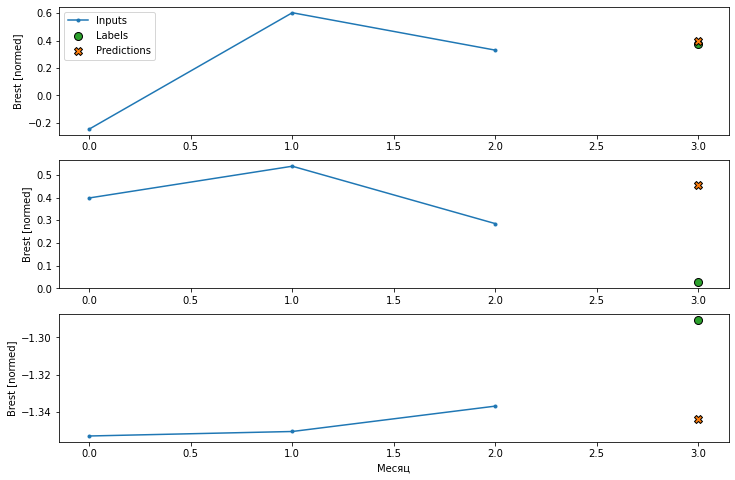

In [48]:
conv_window.plot(multi_step_dense)

Основным недостатком этого подхода является то, что результирующая модель может быть выполнена только с входными окнами именно этой формы. Сверточные модели позволяют решить данную проблему.

### Сверточные нейронные сети
 
Сверточный слой (`tf.keras.layers.Conv1D`) также принимает несколько временных интервалов на вход для каждого прогноза.

Ниже та же самая модель `multi_step_dense`, переписана с использованием свертки. 

In [49]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

При запуске модель выдает данные ожидаемой формы:

In [50]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


Обучаем и проверяем модель ` conv_window` и на выходе она дает производительность аналогичную модели `multi_step_dense`.

In [51]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

5/5 [==============================] - 0s 2ms/step - loss: 0.0365 - mean_absolute_error: 0.1514


Отличие между `conv_model` и `multi_step_dense` моделями заключается в том, что `conv_model` может работать с входными данными любой длины. Сверточный слой принимает на вход скользящее окно:

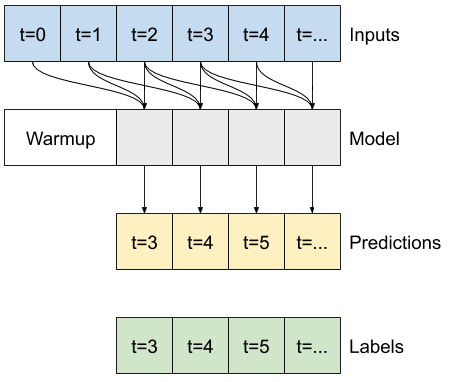

При запуске на более широком входе, модель даст более широкий вывод:

In [52]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Обратите внимание, что вывод короче ввода. Чтобы обучение или построение графиков работало нужно, чтобы метки и прогноз имели одинаковую длину.

In [53]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Brest'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Brest']

In [54]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Теперь построим прогнозы модели в более широком окне. Обратите внимание на 3 временных шага ввода до первого прогноза. Каждый прогноз здесь основан на трех предыдущих временных шагах:

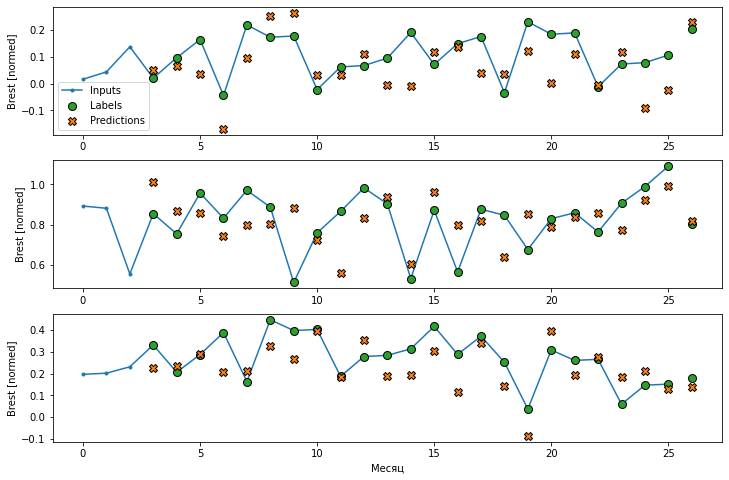

In [55]:
wide_conv_window.plot(conv_model)

### Рекуррентные нейронные сети

Рекуррентные нейронные сети (RNN) это тип нейросетей хорошо приспособленых для временных рядов. RNN обрабатывают временной ряд шаг за шагом, поддерживая внутреннее состояние от временного шага к временному шагу.
В исследовании будем использовать современный вид RNN который называется слой Долгой Кратко-Срочной Памяти (`tf.keras.layers.LSTM`).

Важным параметром при создании слоя для всех RNN слоев в Keras, таких как `tf.keras.layers.LSTM`, является аргумент `return_sequences`. Установка его значения позволяет использовать слой двумя способами:

1. По умолчанию `False`, слой возвращает значение после последнего временного шага, модель дает единственный прогноз: 

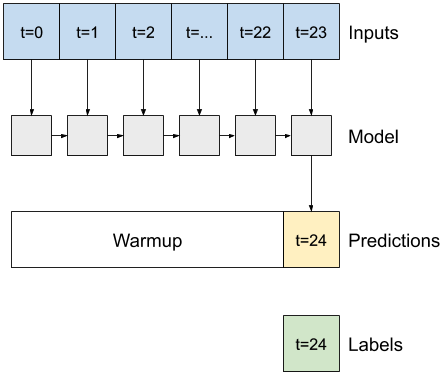

2. Если `True`, слой возвращает прогноз на каждом шаге. Это широко используется для:
  * Соединение слоев RNN. 
  * Обучение модели на нескольких временных шагах одновременно.

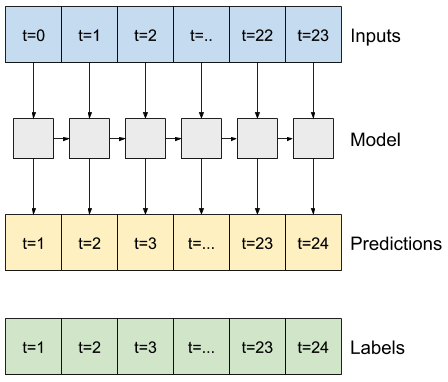

In [56]:
lstm_model = tf.keras.models.Sequential([
    # Форма [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    # Форма => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

С установленным аргументом `return_sequences=True`, модель будет обучаться на 24 месяцах информации в одно время.
Вначале, на первых шагах обучения, это дает пессиместическое представление о производительности, но потом модель становится лучше чем `linear` и `dense` которые мы рассмотрели выше.

In [57]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


In [58]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 16ms/step - loss: 0.0190 - mean_absolute_error: 0.1012


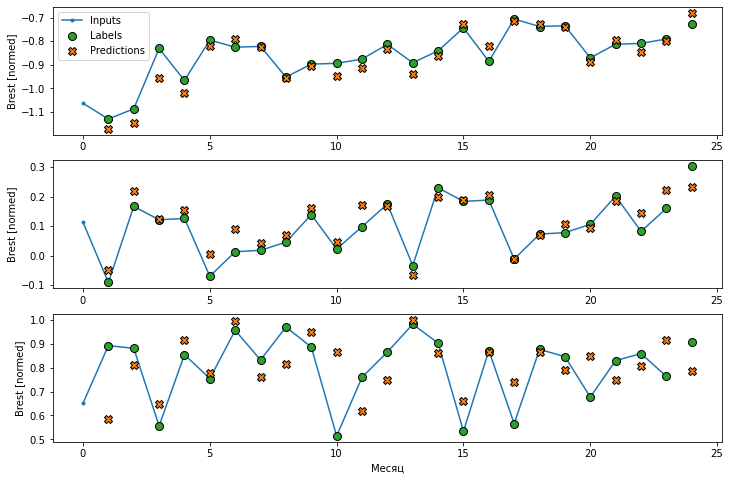

In [59]:
wide_window.plot(lstm_model)

### Производительность (точность прогнозирования)

С этим набором данных каждая из моделей показала себя немного лучше, чем предыдущая::

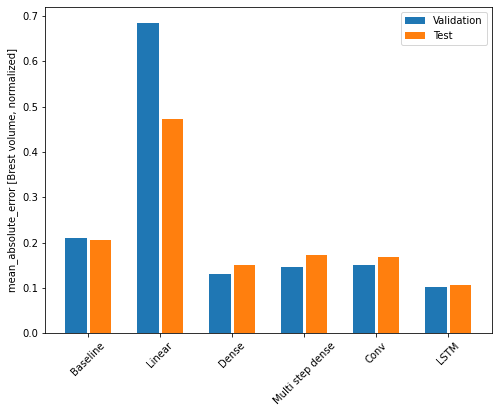

In [60]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Brest volume, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [61]:
for name, value in performance.items():
  print(f'{name:18s}: {value[1]:0.4f}')

Baseline          : 0.2064
Linear            : 0.4723
Dense             : 0.1501
Multi step dense  : 0.1728
Conv              : 0.1684
LSTM              : 0.1074


### Модели мульти-параметрического прогнозирования

Исследованые модели прогнозировали один параметр, объем транспортировки в направлении Бреста `Brest`, для одного временного шага.

Все рассмотренные модели преобразовать для прогнозирования значений всех входных параметров путем включение всех свойств в метки `labels` (`example_labels`):

In [62]:
single_step_window = WindowGenerator(
    # `WindowGenerator` возвращает все параметры как метки для обучения 
    # аргумент `label_columns` не задан.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 13)
Labels shape (batch, time, features): (32, 24, 13)


Ось `features` для меток стала такой-же глубина как и для входных данных, а не `1`.

#### Исходный уровень

Исходная модель также может быть использована (`Baseline`), но сейчас она будет повторять все значение, а не только описанные в `label_index`:

In [63]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [64]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 4ms/step - loss: 0.6877 - mean_absolute_error: 0.4756


#### Плотная нейросеть

In [65]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [66]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 4ms/step - loss: 0.0945 - mean_absolute_error: 0.1989


#### Рекурентная нейросеть


In [67]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

4/4 [==============================] - 0s 8ms/step - loss: 0.0344 - mean_absolute_error: 0.1213

CPU times: user 27 s, sys: 3.28 s, total: 30.3 s
Wall time: 27 s


<a id="residual"></a>

#### Остаточные соединения

Модель `Baseline` использует свойство данных, что они не меняются от шага к шагу коренным образом.
Каждая модель, обученная в в исследовании до сих пор, была случайным образом инициализирована, а затем в процессе обучения должна была узнать, что результат - небольшое изменение по сравнению с предыдущим временным шагом.

Хотя мы можем обойти эту проблему с помощью тщательной инициализации, проще встроить ее в структуру модели.

В анализе временных рядов часто строят модели, которые вместо предсказания следующего значения предсказывают, как значение изменится на следующем временном шаге. 

На рисунке показано как используется знание того, что изменение должно быть небольшим.

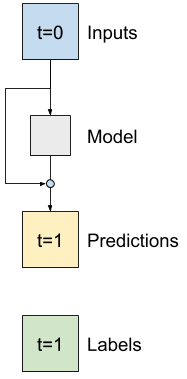

По существу, эта связь инициализирует модель, по подобию Baseline. Это помогает моделям быстрее сходиться с лучшей производительностью.

Этот подход можно использовать в сочетании с любой моделью, рассмотренной в работе. Здесь, он применяется к модели LSTM.

In [68]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # Прогноз для каждого входного временного шага
    # из предудущего временного шага плюс дельта
    # вычисленная моделью.
    return inputs + delta

In [69]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # Прогнозируемая дельта изначальна мала,
        # поэтому инициализирует выходной слой нулями.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

4/4 [==============================] - 0s 10ms/step - loss: 0.0369 - mean_absolute_error: 0.1135

CPU times: user 26.9 s, sys: 3.08 s, total: 30 s
Wall time: 27.7 s


#### Производительность

Ниже показана общая производительсноть моделей мульти-параметрического прогнозирования.

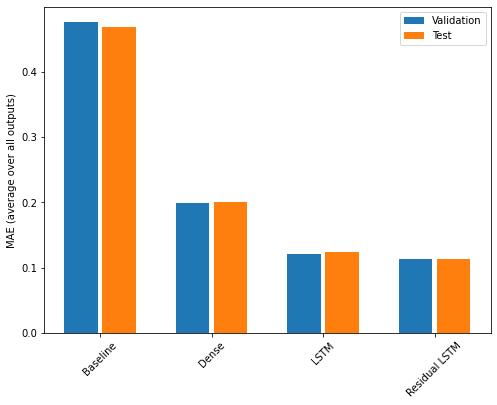

In [70]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [71]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.4688
Dense          : 0.2005
LSTM           : 0.1235
Residual LSTM  : 0.1129


Производительность расчитана как средняя для всех выходов модели.

## Мульти-шаговые модели

Модели с одним выход и мульти-параметрические модели рассматриваемые в исследовании, сделали прогноз на один раз шаг, один месяц в будущее.

Для практического применения необходимо прогнозировать динамику изменения объемов транспортировки на 1-2 года в будущее, т.е. на 12-24 шагов. 

При многоэтапном прогнозировании модели необходимо научиться прогнозировать диапазон будущих значений. Таким образом, в отличие от одношаговой модели, в которой прогнозируется только одна будущая точка, многоступенчатая модель прогнозирует последовательность будущих значений.

Есть два грубых подхода к этому:
1. Прогнозы одиночных снимков, при которых прогнозируется сразу весь временной ряд.
2. Авторегрессионные прогнозы, когда модель делает только одношаговые прогнозы, а ее выходные данные возвращаются в качестве входных данных.

Для многошаговой модели обучающие данные снова состоят из помесячных выборок. Однако здесь модели научатся предсказывать 12 месяцев будущего, учитывая 12 месяцев прошлого.

Total window size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13 14 15 16 17 18 19 20 21 22 23]
Label column name(s): None

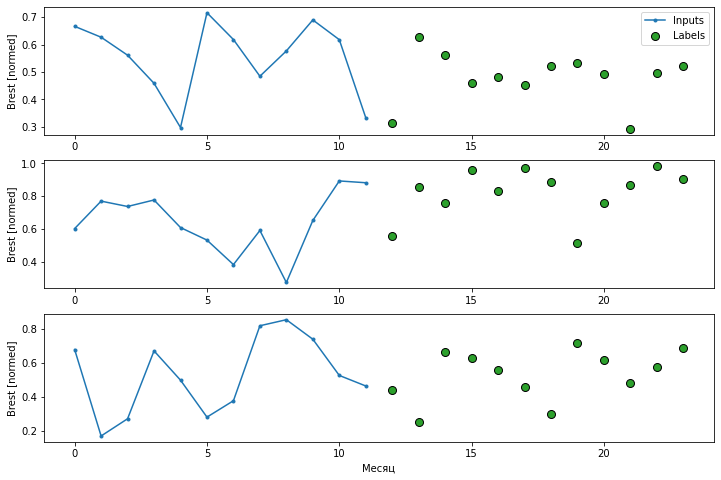

In [72]:
OUT_STEPS = 12
multi_window = WindowGenerator(input_width=12,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Исходный уровень

Простой базовый план для этой задачи - повторить последний временной шаг ввода для необходимого количества временных шагов вывода:

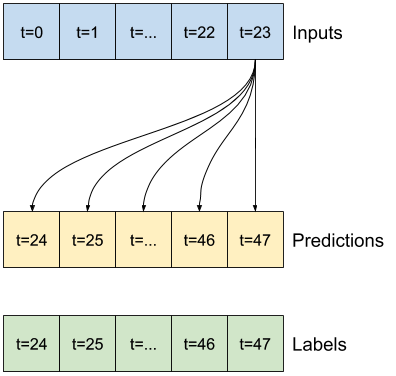

4/4 [==============================] - 0s 2ms/step - loss: 0.6506 - mean_absolute_error: 0.4709


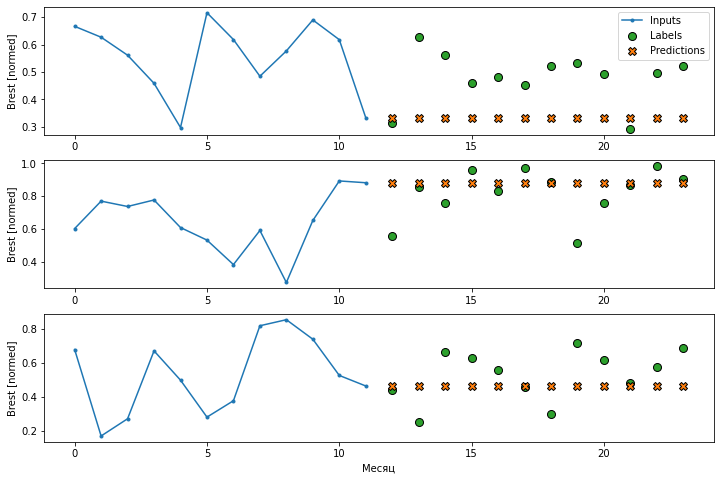

In [73]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Поскольку эта задача состоит в том, чтобы предсказать будущее на 12 месяцев с учетом 12 месяцев прошлого, другой простой подход - повторить предыдущий год, предполагая, что новый будет аналогичным:

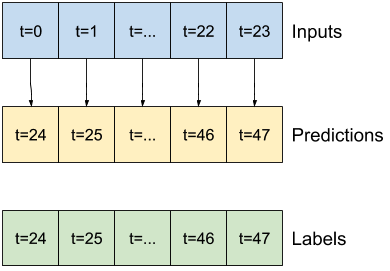

4/4 [==============================] - 0s 2ms/step - loss: 0.1561 - mean_absolute_error: 0.2469


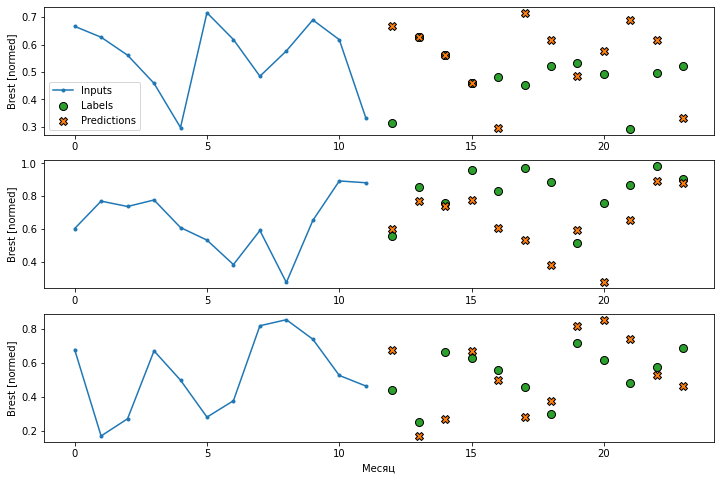

In [74]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Однократные модели

Одним из высокоуровневых подходов к этой проблеме является использование «однократной» модели, в которой модель выполняет прогнозирование всей последовательности за один шаг.

Это может быть осуществлено эффективно, используя tf.keras.layers.Dense с OUT_STEPS*features выходными блоками. Модели просто нужно изменить вход к требуемому выходу (OUTPUT_STEPS, features).

#### Линейная модель

Простая линейная модель, основанная на последнем временном шаге ввода, работает лучше, чем любая базовая линия, но имеет недостаточную мощность. Модель должна предсказать `OUTPUT_STEPS` шагов по времени, из одного временного шага входного сигнала с линейной проекцией. Она может фиксировать только низкоразмерный срез поведения.

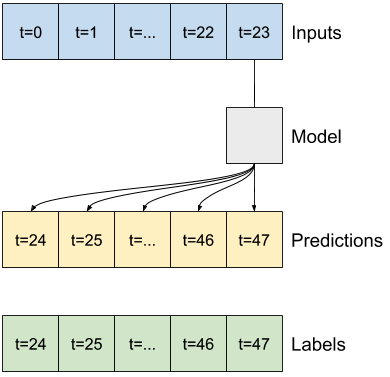

4/4 [==============================] - 0s 5ms/step - loss: 0.2212 - mean_absolute_error: 0.3402


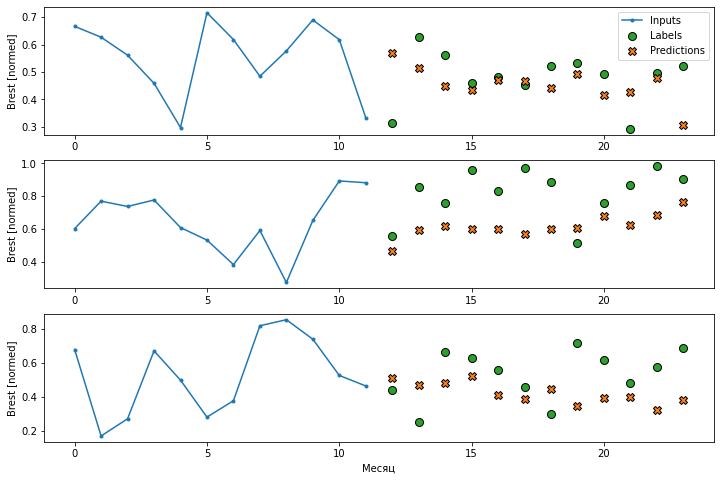

In [75]:
multi_linear_model = tf.keras.Sequential([
    # Берем последний времянной шаг.
    # Форма [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Форма => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Форма => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Плотная модель

Добавим `tf.keras.layers.Dense` между входом и выходом, чтобы добавить больше мощности линейной модели, но модель по врешнему основана на одном временном шаге.

4/4 [==============================] - 0s 4ms/step - loss: 0.1303 - mean_absolute_error: 0.2093


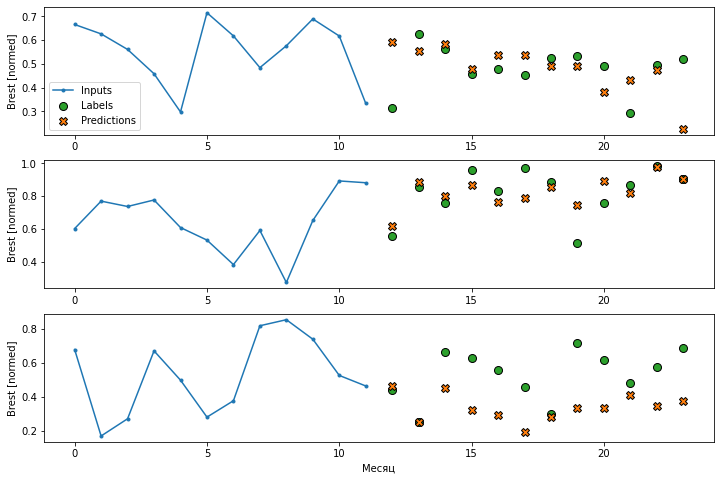

In [76]:
multi_dense_model = tf.keras.Sequential([
    # Берем последний времянной шаг.
    # Форма [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Форма => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Форма => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Форма => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### Сверточная нейронная сеть

Сверточная модель делает прогнозы на основе истории фиксированной ширины, что может привести к лучшей производительности, чем плотная модель, поскольку она может видеть, как вещи меняются с течением времени:

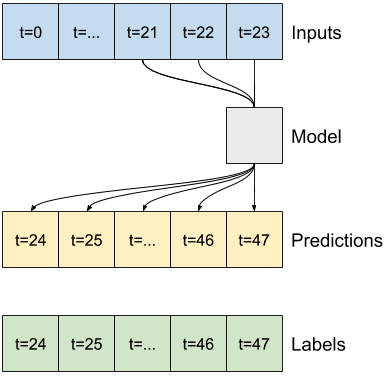

4/4 [==============================] - 0s 3ms/step - loss: 0.0646 - mean_absolute_error: 0.1537


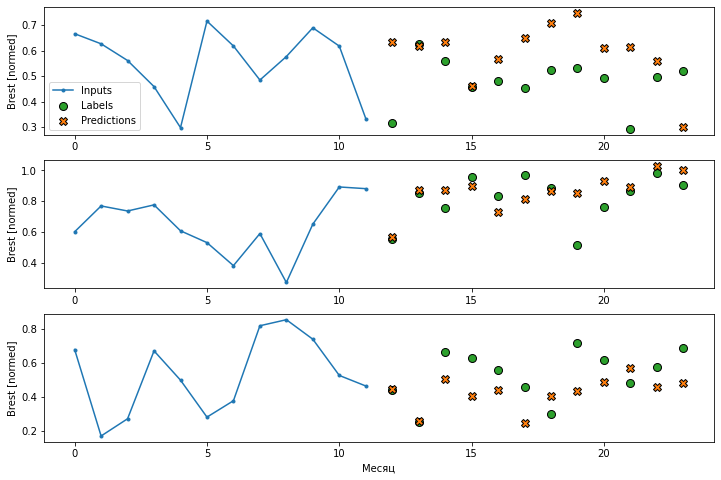

In [77]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Форма [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Форма => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(512, activation='relu', kernel_size=(CONV_WIDTH)),
    # Форма => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Форма => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### Рекуррентная нейронная сеть

Рекуррентная модель может научиться использовать длинную историю входных данных, если это имеет отношение к прогнозам, которые делает модель. Здесь модель будет накапливать внутреннее состояние в течение 12 месяцев, прежде чем сделать единичный прогноз на следующие 12 месяцев.

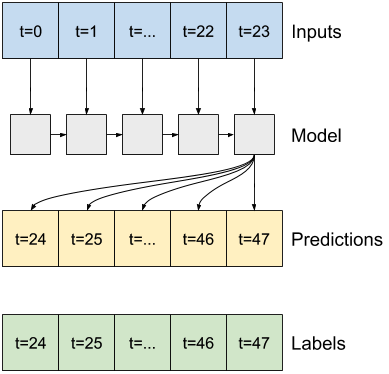

4/4 [==============================] - 0s 15ms/step - loss: 0.0213 - mean_absolute_error: 0.0959


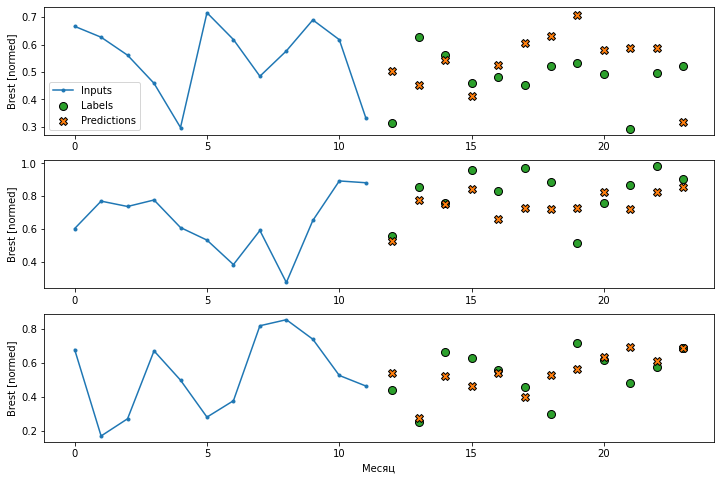

In [78]:
multi_lstm_model = tf.keras.Sequential([
    # Форма [batch, time, features] => [batch, lstm_units].
    # Добавляем `lstm_units`.
    tf.keras.layers.LSTM(256, return_sequences=False),
    # Форма => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Форма => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Авторегрессионная модель

Все рассмотренные в работе модели предсказывают всю выходную последовательность за один шаг.

В некоторых случаях модели может быть полезно разложить этот прогноз на отдельные временные шаги. Тогда выход каждой модели может быть подан обратно в себя на каждом шагу и предсказания могут быть обусловлено предыдущим, как в классических генерирующих последовательности рецидивирующих нейронных сетях.

Одним из явных преимуществ моделей этого стиля является то, что ее можно настроить для вывода прогнозов различной длины.

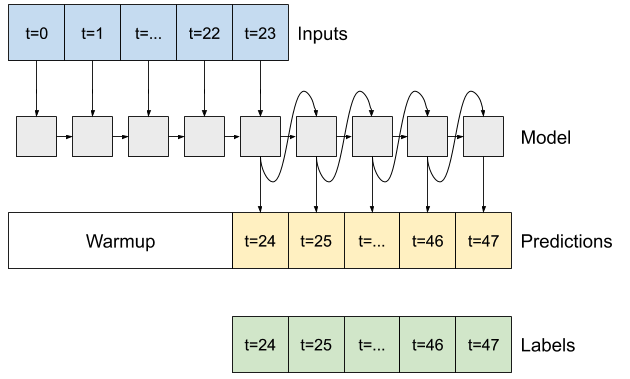

#### Рекуррентная нейронная сеть

Для исследования возможностей авторегрессионной модели используем рекуррентную нейронную сеть, тойже формы, что использовали для прогноза на 1 шах в будущее. 

In [79]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Также обернем LSTMCell в RNN, чтобы упростить метод «разогрева».
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [80]:
feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)

In [81]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

Этот метод возвращает один прогнозный временной шаг и внутреннее состояние `LSTM`:

In [82]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 13])

Теперь продолжаем передавать состояние `RNN` на вход модели для следующего шага.

In [83]:
def call(self, inputs, training=None):
  # Используйте TensorArray для захвата динамически развернутых выходных данных.
  predictions = []
  # Инициализируем состояние LSTM
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Выполните остальные шаги прогнозирования.
  for n in range(1, self.out_steps):
    # Используйте в качестве входных данных последний прогноз.
    x = prediction
    # Выполните один шаг LSTM.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Преобразовываем LSTM выход в прогноз.
    prediction = self.dense(x)
    # Добавьте прогноз к выходным данным.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Тестирование модели на пробных данных:

In [84]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 12, 13)


Обучение модели:

4/4 [==============================] - 0s 6ms/step - loss: 0.0609 - mean_absolute_error: 0.1725


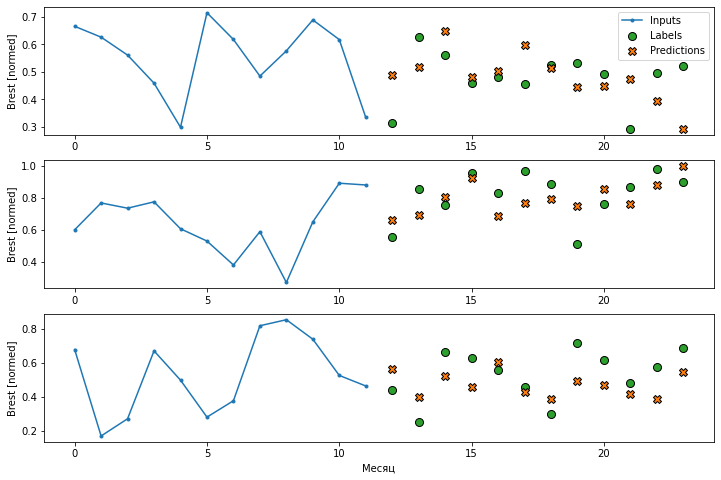

In [85]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Производительность

Очевидно, что работа сложных моделей определяется степенью настройки

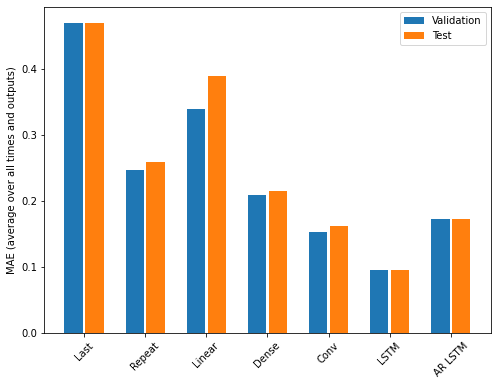

In [86]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

Метрики для моделей с несколькими выходами в первой половине исследования показывают производительность, усредненную по всем функциям вывода. Характеристики для мульти-шаговых моделей аналогичны, потому что также усреднены по временным шагам вывода.

In [87]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.4694
Repeat  : 0.2592
Linear  : 0.3895
Dense   : 0.2155
Conv    : 0.1625
LSTM    : 0.0963
AR LSTM : 0.1727


Прирост, достигнутый при переходе от плотной модели к сверточным, составляет всего несколько процентов. Рекуррентная модель демонстрирует качественный шаг в прогнозировании, а авторегрессионная модель работает явно хуже. Таким образом, эти более сложные подходы, возможно, не стоит применять на исходном наборе данных. Для мульти-шагового прогноза наилучшие характеристики показала рекуррентная нейронная сеть на основе слоя LSTM.